# Diamond EP - EDA with updated & new database

Here repeat previous initial analysis to identify the effect of new feature TOT_MOLWEIGHT, and the new dabase using 3dii instead of dials.

In [1]:
import sys
dirpath = r'C:\Users\César\PycharmProjects\Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, np, pd, plt, plot_original_data
plt.style.use("ggplot")

------------------
Dials


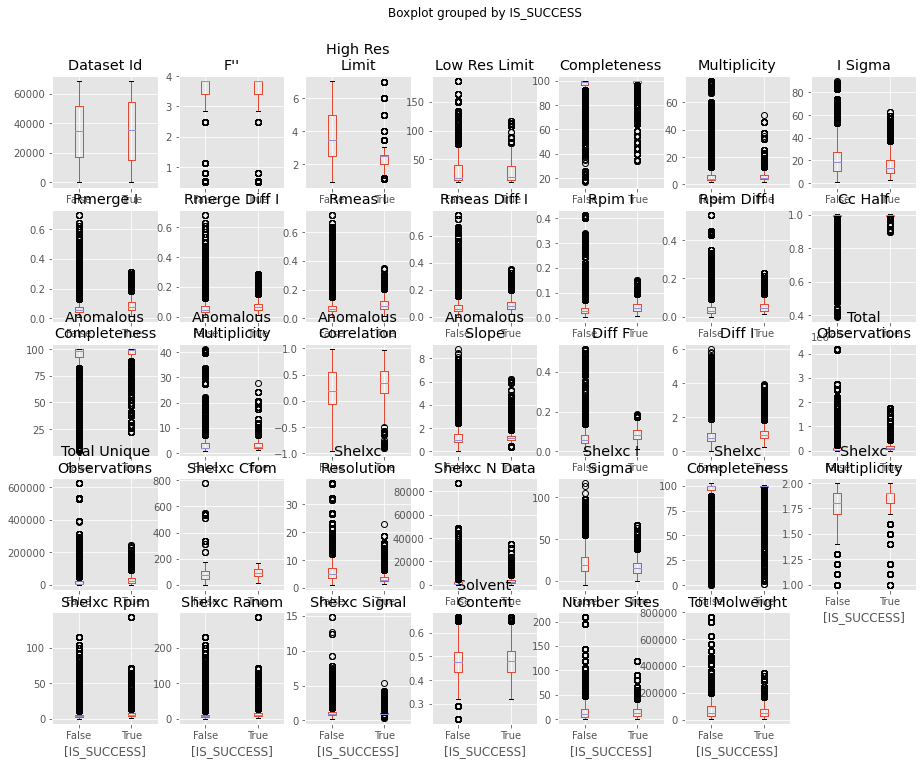

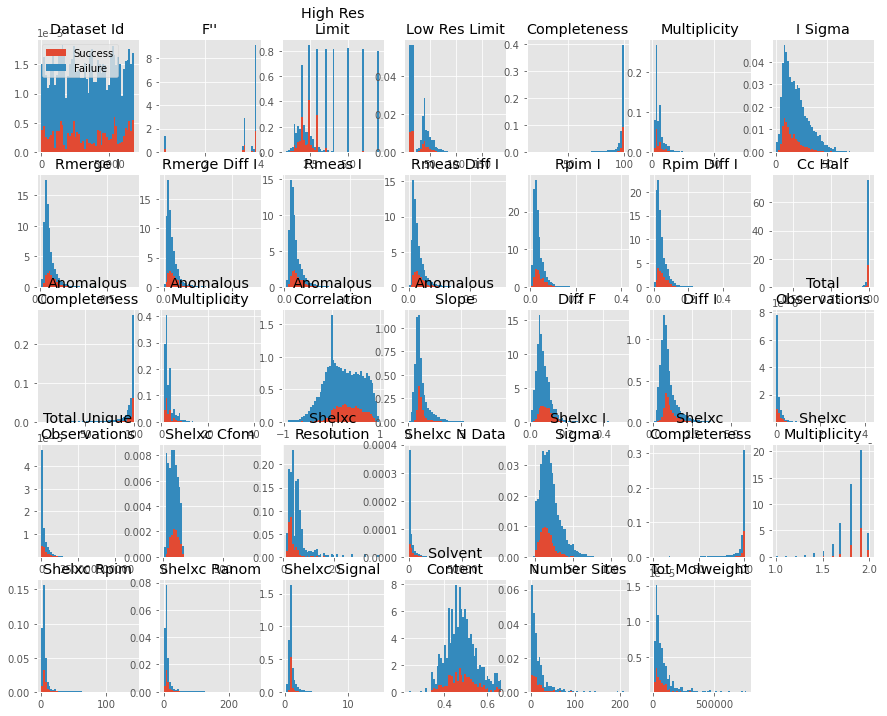

------------------
------------------
3Dii


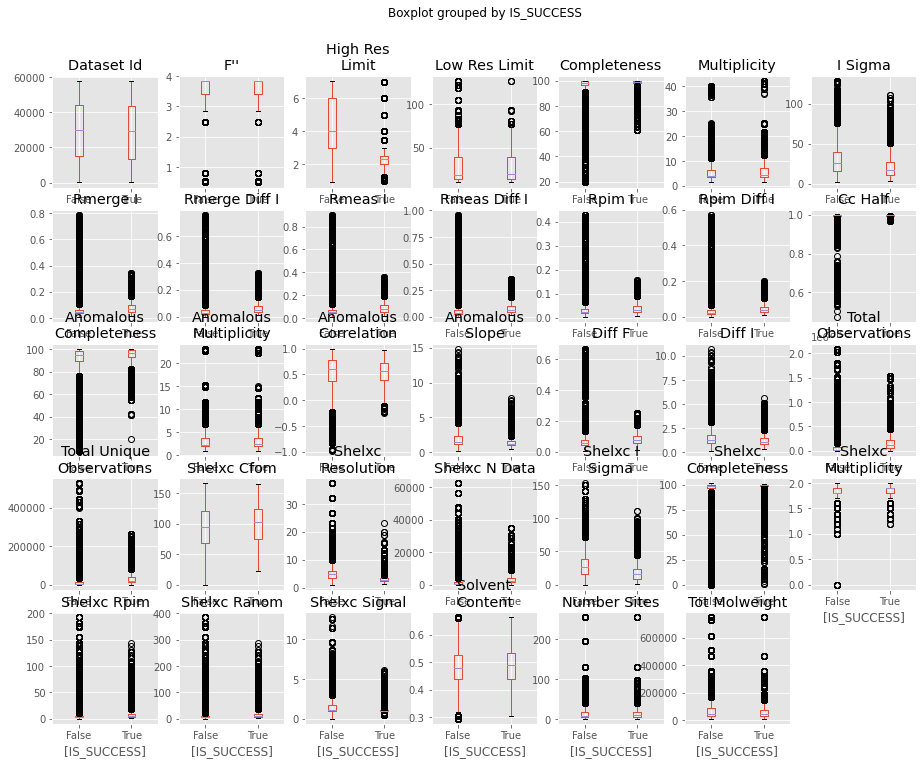

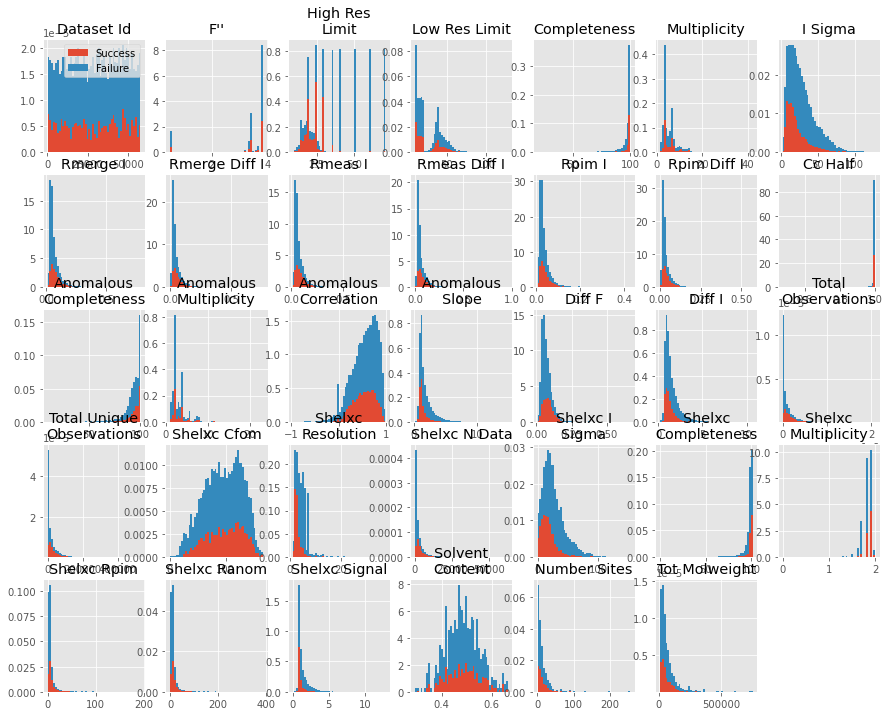

------------------


In [2]:
from textwrap import wrap

# for each database
for db_kind, v in data.items():
    print("------------------", db_kind.title(), sep="\n")
    # prepare data
    x, y, union = v.x, v.y, v.union
    x_win, x_lose = x[y == 1], x[y == 0]

    # show boxplots/histograms (workaround for different ylims)
    layout, figsize = (5, 7), (15, 12)
    fig_box, fig_hist = [plt.figure(figsize=figsize) for i in range(2)]

    # show boxplot/histogram of each feature
    for i, colname in enumerate(x.drop("SPACEGROUP", axis=1)):
        pretty_colname = colname.replace("_", " ").title()
        title = "\n".join(wrap(pretty_colname, 13))
        section = union.loc[:, [colname, "IS_SUCCESS"]]

        # add boxplot
        ax_box = fig_box.add_subplot(*layout, i+1)
        section.boxplot(by="IS_SUCCESS", ax=ax_box)
        ax_box.set_title(title)

        # create stacked histograms
        ax_hist = fig_hist.add_subplot(*layout, i+1)
        ax_hist.hist([x_win[colname], x_lose[colname]], bins=50, stacked=True,
                density=True, label=["Success", "Failure"])
        ax_hist.set_title(title)
        if i==0:
            ax_hist.legend()
            
    # show results
    #fig_box.tight_layout()
    #fig_hist.tight_layout()
    plt.show()
    print("------------------")

From looking at the **Histograms** one can tell, as before, that the data is **heavily skewed** in most feature in both datasets, with a significant number of outliers.

The boxplots also confirm this skewing from the large number of outliers in most plots. Also, when compared to failed sweeps, *successful* cases appear to have:

- **Lower high resolution limit** average
- **Lower low resolution limit** upper bound
- **Higher (SHELXC) completeness** average & lower bound
- **Lower I Sigma** average & upper bound
- **Lower Rmerge/Rmeas/Rpim (diff) I** upper bound
- **Higher CC half** lower bound
- **Higher anomalous completeness** average & lower bound
- **Lower anomalous multiplicity** upper bound
- **Higher anomalous correlation** average & lower bound (especially for 3dii)
- **Pinpoint anomalous slope** & lower upper bound
- **Lower Diff F/I** upper bound
- **Slightly higher total (unique) obvservations** average & lower upper bound
- **Slightly higher SHELXC cfom** average & lower bound
- **Lower SHELXC resolution** average & upper bound
- **Higher SHELXC N data** average BUT lower upper bound
- **Lower SHELXC I sigma/signal** average & upper bound
- **Slightly higher solvent content** average & lower bound

For the most part, the dials and 3dii produce similar results. However, **3dii appears to have  less outliers than dials** in most features (e.g. SHELXC cfom), and the **success/failures appear to occasionally be more distinguishable** (e.g. anomalous correlation).

In [3]:
for k, v in data.items():
    print(k.title(), v.y.describe(), "-"*30,  sep="\n")

Dials
count     118979
unique         2
top        False
freq       95611
Name: IS_SUCCESS, dtype: object
------------------------------
3Dii
count     144688
unique         2
top        False
freq      103308
Name: IS_SUCCESS, dtype: object
------------------------------


3dii has more datapoints than dials, and also a **higher success rate**.

## Correlation & Indicators

The previously done correlation tables are then repeated.

Dials
HIGH_RES_LIMIT              -0.388071
SHELXC_RESOLUTION           -0.219038
DIFF_F                       0.180354
SHELXC_CFOM                  0.173494
SHELXC_MULTIPLICITY          0.165739
SHELXC_I_SIGMA              -0.165080
I_SIGMA                     -0.154474
TOTAL_UNIQUE_OBSERVATIONS    0.143682
ANOMALOUS_CORRELATION        0.143208
RMERGE_I                     0.137557
SHELXC_N_DATA                0.130965
TOTAL_OBSERVATIONS           0.130063
RMEAS_I                      0.129903
RMERGE_DIFF_I                0.100598
RMEAS_DIFF_I                 0.099903
RPIM_I                       0.097749
SHELXC_COMPLETENESS          0.095799
TOT_MOLWEIGHT               -0.095410
ANOMALOUS_COMPLETENESS       0.093418
RPIM_DIFF_I                  0.093315
DIFF_I                       0.090880
COMPLETENESS                 0.086272
SHELXC_SIGNAL               -0.052108
CC_HALF                      0.045605
SHELXC_RANOM                 0.045040
SHELXC_RPIM                  0.045032
NUMBER

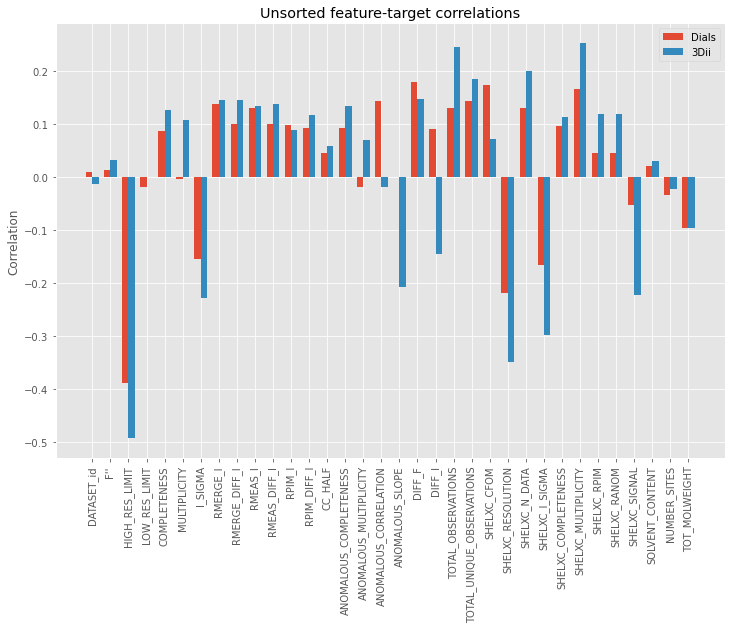

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
rects = []
bar_wd = 0.35
hoz_main = np.arange(len(data["dials"].x.columns)-1)

for k, v in data.items():
    # prepare data
    x, y = v.x, v.y
    corr = x.corrwith(y)
    corr_sorted = corr.sort_values(ascending=False, key=lambda a: abs(a))
    
    # get horizontal positions
    hoz = hoz_main - bar_wd/2 if k=="dials" else hoz_main + bar_wd/2
    
    # create bar plot
    rects.append(ax.bar(hoz, corr, bar_wd, label=k.title()))
    
    print(k.title(), corr_sorted, "------------------", sep="\n")
    
# text and labels
ax.set_ylabel("Correlation")
ax.set_title("Unsorted feature-target correlations")
plt.xticks(hoz_main, corr.index, rotation=90)
ax.legend()
    
plt.show()

The following can be noted regarding feature-target correlation:

- In both pipelines (dials & 3dii), **high resolution limit** and **SHELXC resolution**, which are known to be inter-correlated, dominate.
- Followed by **(SHELXC) I sigma** and **SHELXC multiplicity**.
- Also high up are **total (unique) observations** and **SHELXC N data**, representing the amount of datapoints available, or simply the intensity of the signal.
- **Diff F** is high up in the tables.
- **Anomalous correlation**, which has high correlation in dials, is among the lowest in 3dii, a similar discrepancy is also seen with **anomalous slope**
- The least correlated include: **CC half**, **low resolution limit**, **f''**, **solvent content**, **number of sites** and **dataset id**.
- New feature, **total molecular weight** has average correlation.

Even though the correlation remains similar in both pipelines for various features, there are a few **significiant discrepancies** (e.g. anomalous slope). Also, 3dii seems to have consistently **higher correlation magnitudes** than dials.


The data is then grouped by sweep result and each mean analysed.

In [5]:
pd.set_option("display.max_rows", None)

for k, v in data.items():
    # prepare data
    x, y = v["x"], v["y"]
    union = pd.concat([x, y], axis=1)
    
    # take grouped averages
    grp_meds = union.groupby("IS_SUCCESS").agg(["mean", "median"])
    rel_diff = abs(1 - grp_meds.iloc[1, :] / grp_meds.iloc[0, :])
    rel_diff = rel_diff.sort_values(ascending=False)
    print(k.title(), rel_diff * 100, "-"*50, sep="\n")

Dials
TOTAL_OBSERVATIONS         median    299.089507
TOTAL_UNIQUE_OBSERVATIONS  median    280.779055
SHELXC_N_DATA              median    272.136752
ANOMALOUS_CORRELATION      median     92.737430
TOTAL_OBSERVATIONS         mean       68.016680
SHELXC_N_DATA              mean       65.904965
TOTAL_UNIQUE_OBSERVATIONS  mean       65.211508
ANOMALOUS_CORRELATION      mean       61.986343
RPIM_DIFF_I                median     45.161290
RMEAS_DIFF_I               median     42.592593
DIFF_F                     median     42.105263
RMERGE_DIFF_I              median     41.860465
RMERGE_I                   median     41.818182
HIGH_RES_LIMIT             mean       41.140503
SHELXC_RESOLUTION          mean       40.036881
                           median     40.000000
RMEAS_I                    median     38.095238
RPIM_I                     median     35.714286
HIGH_RES_LIMIT             median     28.571429
DIFF_F                     mean       27.951969
I_SIGMA                    median 

This table has already been analysed for dials, whose new feature, **total molecular weight** appears to have average mean/median differences.

Regarding 3dii, the following is noted:

- Same "top" features as dials: **total (unique) observations** and **SHELXC N data**, representing signal intensity.
- Followed by **RMEAS/RMERGE/RPIM Diff I** and **SHELXC RANOM/RPIM**. **High resolution limit** and **SHELXC resolution** are also high up the table.
- Still appears **Diff F** > **Diff I**.
- **Anomalous correlation** no longer among the best ones, now one of the "weakest", together with **(anomalous/SHELXC) completeness**, **f''**, **solvent content**, **dataset id**, **CC half** and **low resolution limit**.
- Overall, relative difference **larger than dials**.

## 3dii Spacegroup Clustering

Before the spacegroups were analysed and grouped by average success rate, 4 groups were found (high, average, low and null). This will be repeated for 3dii.

Dials
Have 54 space groups with total mean success rate of 0.2.
Max of 0.43, min of 0.0.


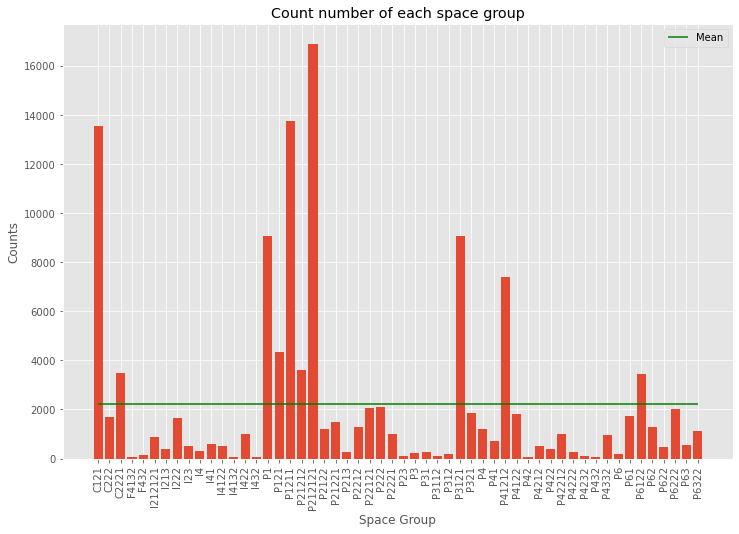

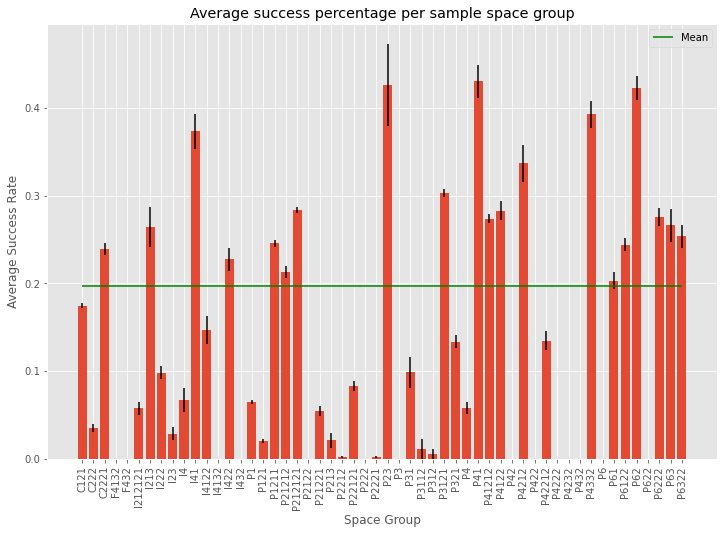

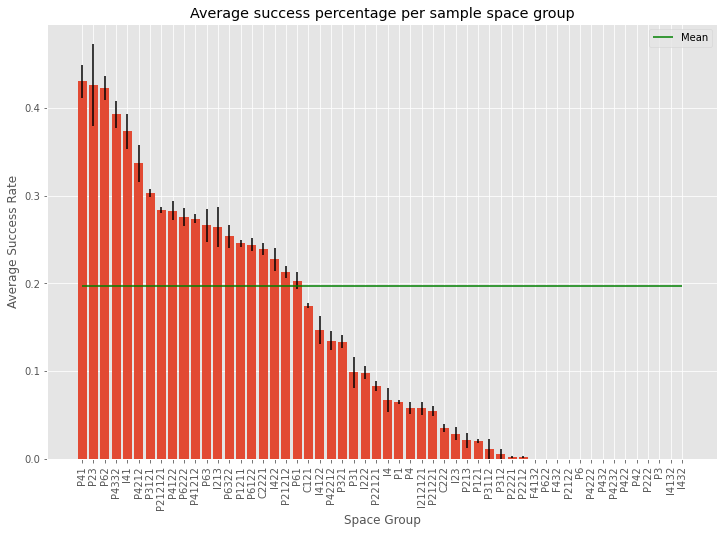

------------------------------------------------------------
3Dii
Have 49 space groups with total mean success rate of 0.29.
Max of 0.54, min of 0.0.


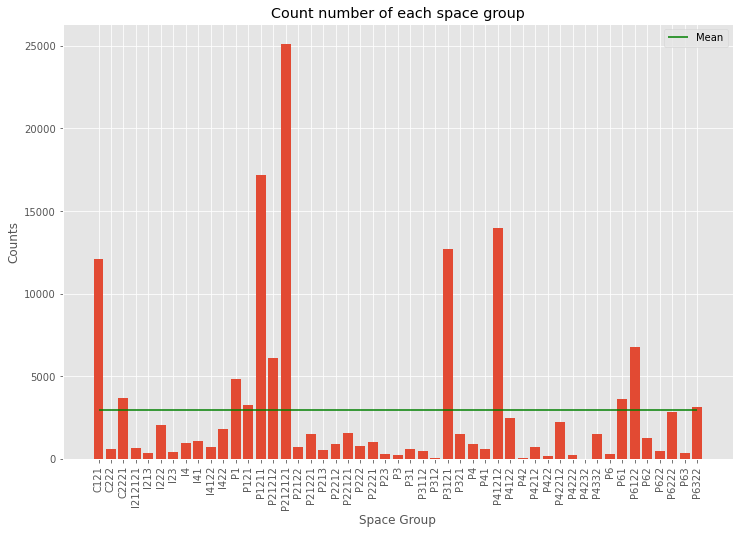

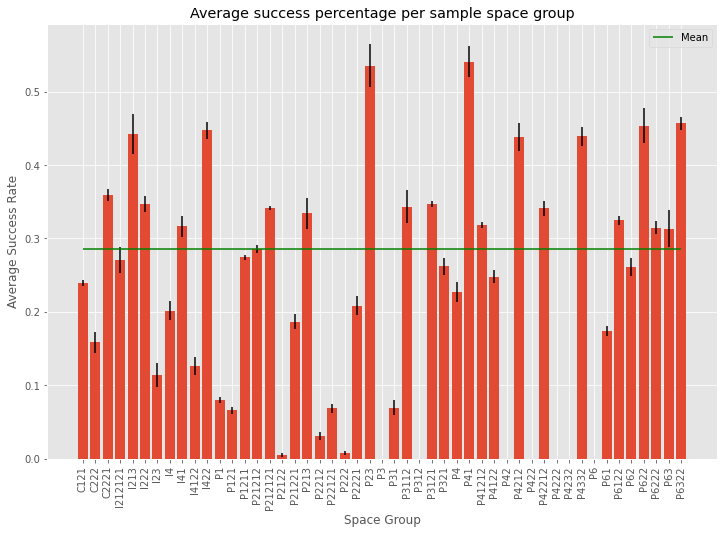

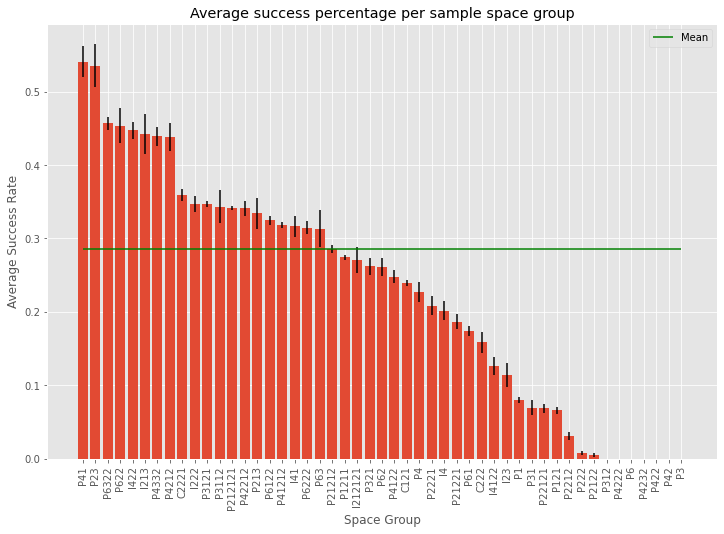

------------------------------------------------------------


In [6]:
def bar_plot(data, count=False, show=True):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.xticks(rotation=90)

    # bar plot & mean line
    if count:
        ax.bar(data.index, data["IS_SUCCESS"])
        ax.hlines(data.iloc[:, 0].mean(), 0, data.index.size - 1, colors="green", label="Mean")
        ax.legend()

        ax.set_title("Count number of each space group")
        ax.set_xlabel("Space Group")
        ax.set_ylabel("Counts")
    else:
        ax.bar(data.index, data["IS_SUCCESS", "mean"], yerr=data["IS_SUCCESS", "sem"])
        ax.hlines(y.mean(), 0, data.index.size - 1, colors="green", label="Mean")
        ax.legend()

        ax.set_title("Average success percentage per sample space group")
        ax.set_xlabel("Space Group")
        ax.set_ylabel("Average Success Rate")

    if show:
        plt.show()
        
    return fig, ax

        

for k, v in data.items():
    print(k.title())
    # prepare data
    x, y, union = v.x, v.y, v.union
    spc_grp = x["SPACEGROUP"]

    # aggregate by mean/SEM or count
    agg = union.groupby("SPACEGROUP").agg(["mean", "sem"])
    agg_sorted = agg.sort_values(by=("IS_SUCCESS", "mean"), ascending=False)
    agg_count = union.groupby("SPACEGROUP").count()
    
    # general description
    print(f"Have {spc_grp.drop_duplicates().size} space groups "
          f"with total mean success rate of {round(y.mean(), 2)}.\n"
          f"Max of {round(agg['IS_SUCCESS', 'mean'].max(), 2)}, "
          f"min of {round(agg['IS_SUCCESS', 'mean'].min(), 2)}.")


    # show distribution
    bar_plot(agg_count, count=True)
    bar_plot(agg)
    bar_plot(agg_sorted)
    print("-"*60)

- Similar to dials, 3dii's spacegroups show **plateaus**, which are more significant for the higher sucess rate spacegroups. However, these start to decrease at a (roughly) constant rate, reaching null.
- **Mean and maximum success rate is higher**. There are also **less null spacegroups**.
- P41 and P23 best performing spacegroups by far in both pipelines. Also common in both *tops* are P4332 and P4212.

Clustering will now be attempted on 3dii data.

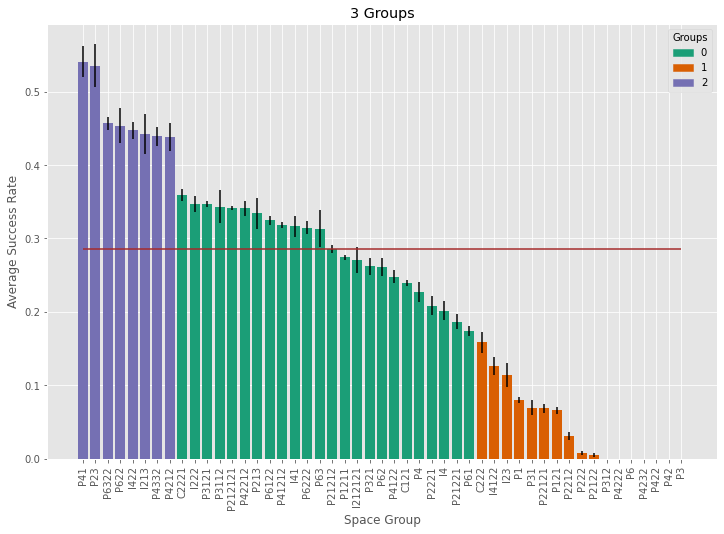

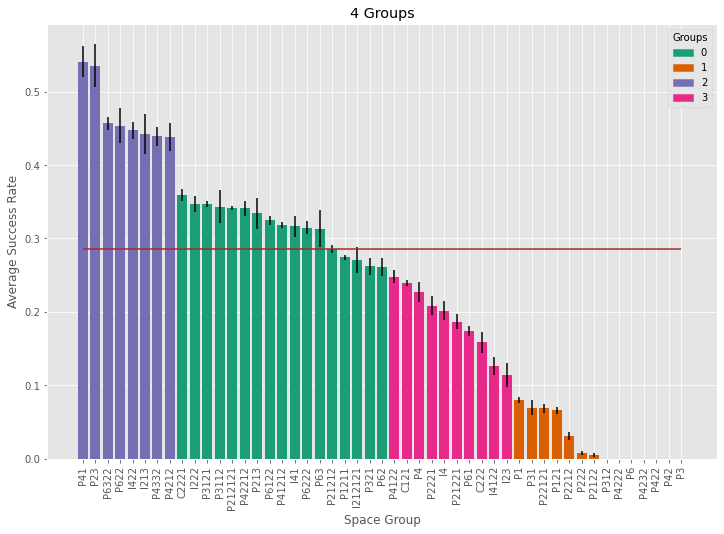

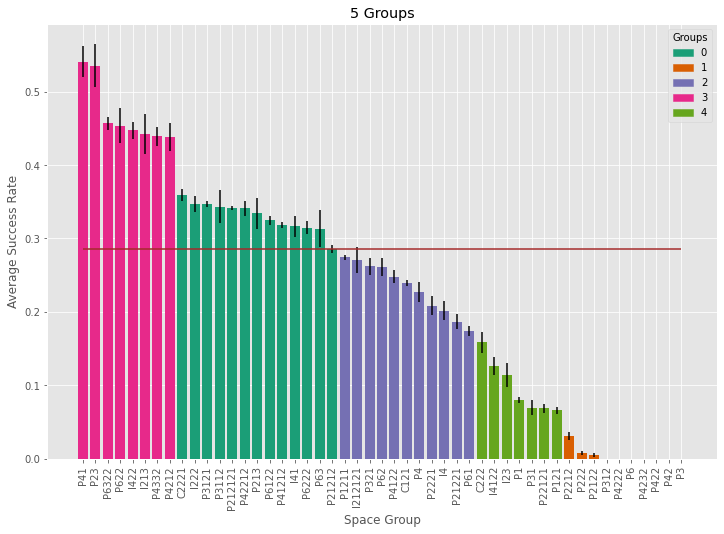

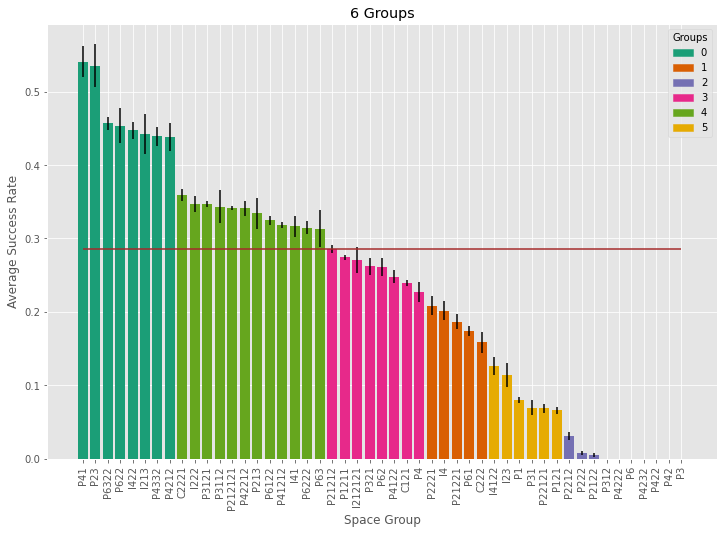

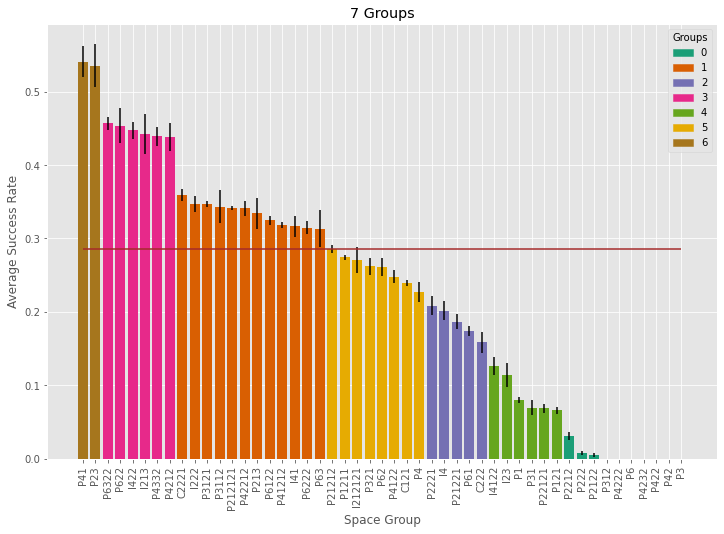

In [7]:
from matplotlib.patches import Patch
from sklearn.cluster import KMeans

def avg_success_bar_plot(mean_sem, n, show=True, sort_legend=True):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.xticks(rotation=90)

    # try ML grouping
    model = KMeans(n_clusters=n)
    pred = model.fit_predict(pd.DataFrame(mean_sem["IS_SUCCESS", "mean"]))
    pred = pd.Series(pred, index=mean_sem.index)

    # colormap
    cmap = plt.get_cmap("Dark2")
    c = pred.map(cmap)
    ax.bar(mean_sem.index, mean_sem["IS_SUCCESS", "mean"],
           yerr=agg_sorted["IS_SUCCESS", "sem"], color=c)
    ax.hlines(y.mean(), 0, mean_sem.index.size - 1, colors="brown", label="Mean")

    # legend
    grps = pd.concat([pred.drop_duplicates(), c.drop_duplicates()], axis=1)
    if sort_legend:
        grps.columns = ["Group", "RGBA"]
        grps.sort_values("Group", inplace=True)
    patches = [Patch(color=v, label=k) for k, v in grps.values]
    ax.legend(handles=patches, title="Groups")

    # text
    ax.set_title(f"{n} Groups")
    ax.set_xlabel("Space Group")
    ax.set_ylabel("Average Success Rate")

    if show:
        plt.show()
    
    return (fig, ax), (pred, c)

for n in [3, 4, 5, 6, 7]:
    # agg sorted from 3dii, last one in previous loop
    avg_success_bar_plot(agg_sorted, n)

The choice of "ideal" number of clusters is more subjective than it was with dials, however the choice is still ~4. In my opinion, **5 clusters is the ideal number**.

The process of grouping data was implemented to a GroupedData class, which inherits from the more general Data class. A GroupedSpacegroup class (from GroupedData) was made as a more specialized way to group by spacegroup using their mean success rate.

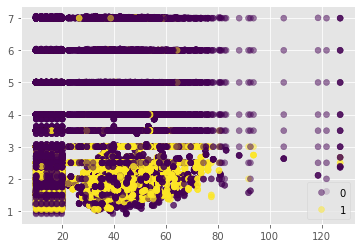

In [8]:
from grouping import GroupedData, GroupedSpacegroup

n = 5
grped_spc_grps = GroupedSpacegroup(x, y)  # 3dii data
grped_spc_grps.group(n)

fig, ax = plt.subplots()
for i, datum in grped_spc_grps:
    x_plot, y_plot = datum.unpack()
    scatter = ax.scatter(x_plot["LOW_RES_LIMIT"], x_plot["HIGH_RES_LIMIT"], c=y_plot, alpha=.5)

# add legend
ax.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1])
plt.show()

## LDA & PCA

From this, one could expect 3dii to perform better in distinguishing sucess. To check it, LDA and PCA are attempted.

Dials


<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


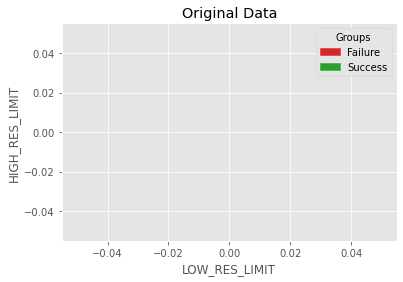

> ('lda', LinearDiscriminantAnalysis())


<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


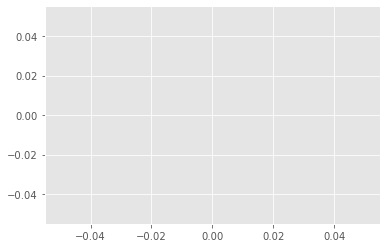

> ('pca', PCA())


<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


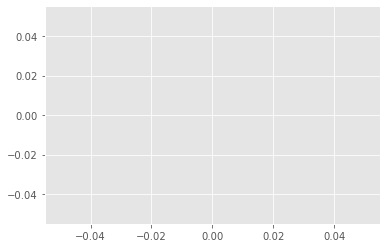

------------------------------------------------------------
3Dii


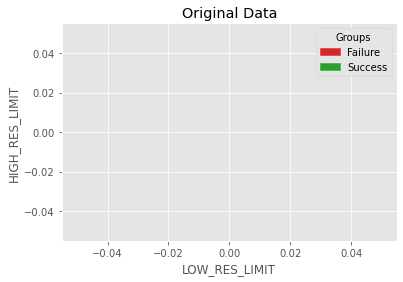

> ('lda', LinearDiscriminantAnalysis())


<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


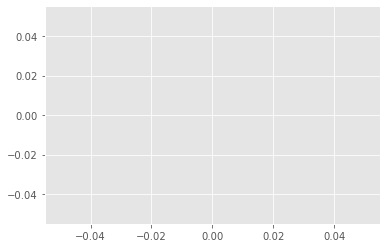

> ('pca', PCA())


<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


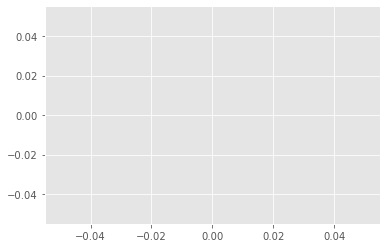

------------------------------------------------------------


In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# create pipelines
#col_trsf = ColumnTransformer([("scaler", StandardScaler(), x.drop("SPACEGROUP", axis=1).columns)], remainder="passthrough")
scaler = StandardScaler()
model_lda = Pipeline([("scaler", scaler),
                      ("lda", LinearDiscriminantAnalysis())])
model_pca = Pipeline([("scaler", scaler),
                      ("pca", PCA())])


for k, v in data.items():
    print(k.title())
    x, y = v.unpack()
    X = x.drop("SPACEGROUP", axis=1)
    
    # plot original data
    (_, _), (cmap, c, patches) = plot_original_data("LOW_RES_LIMIT", "HIGH_RES_LIMIT", X, y)
    
    for model in (model_lda, model_pca):
        print(">", model.steps[1])
        # fit & transform data
        x_new = model.fit_transform(X, y)

        # choose tranformed coords
        fig, ax = plt.subplots()
        x_plot = x_new[:, 0]
        try:  # case PCA
            y_plot = x_new[:, 1]
        except IndexError:  # case LDA
            y_plot = np.zeros_like(x_plot)
        
        # plot transformed data
        ax.scatter(x_plot, y_plot, c=c)
        plt.show()
    print("-"*60)

LDA and PCA do a **reasonable** job of clustering the data by success/failure, however there is still **significant overlap**.

To test their effectiveness, a KMeans algorithm will be used with each one and the F1 score used as a quality indicator.

Dials
> basic
> pca
> lda
> pca_lda


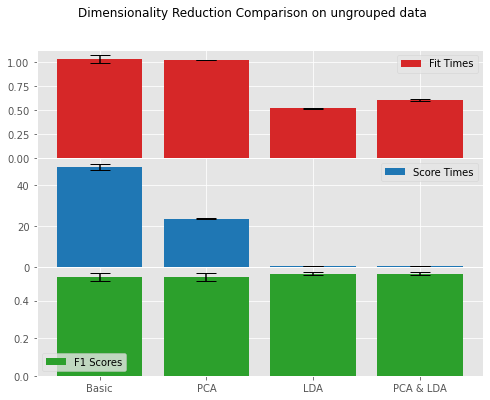

High : High data with shape (4160, 35) - 2 categories
> basic
> pca
> lda
> pca_lda


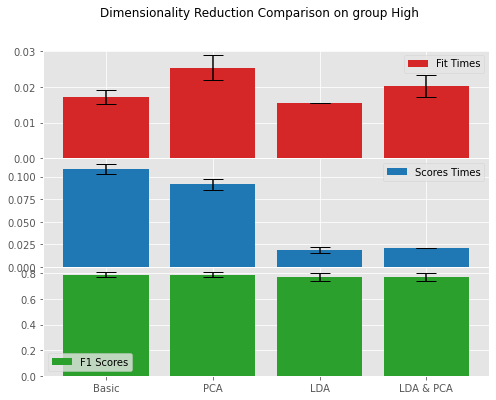

Average : Average data with shape (79815, 35) - 2 categories
> basic
> pca
> lda
> pca_lda


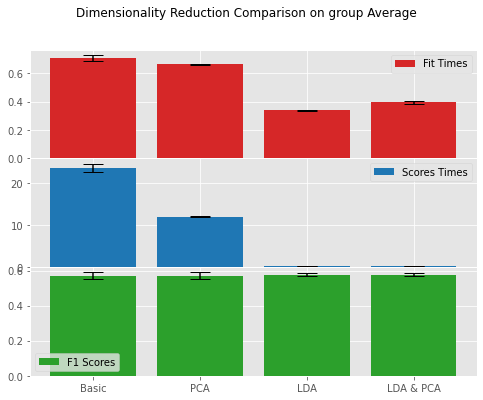

Low : Low data with shape (20299, 35) - 2 categories
> basic
> pca
> lda
> pca_lda


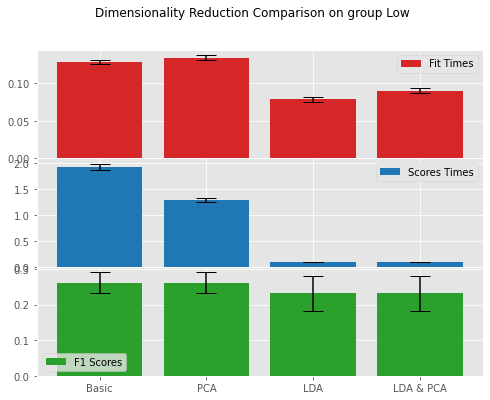

Null : Null data with shape (14705, 35) - 2 categories
> basic
> pca
> lda
> pca_lda


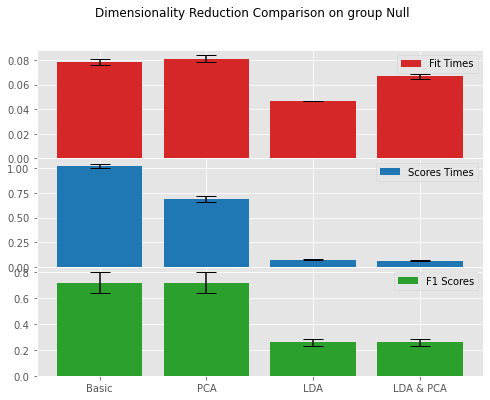

------------------------------------------------------------
3Dii
> basic
> pca
> lda
> pca_lda


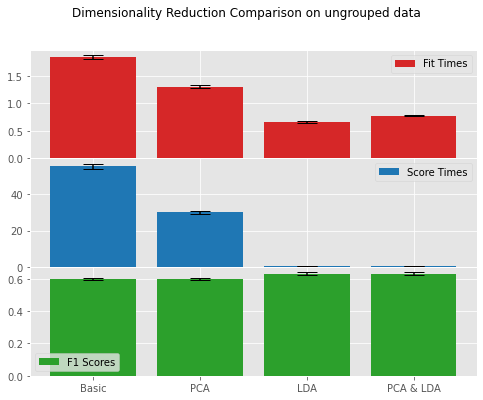

High : High data with shape (8714, 35) - 2 categories
> basic
> pca
> lda
> pca_lda


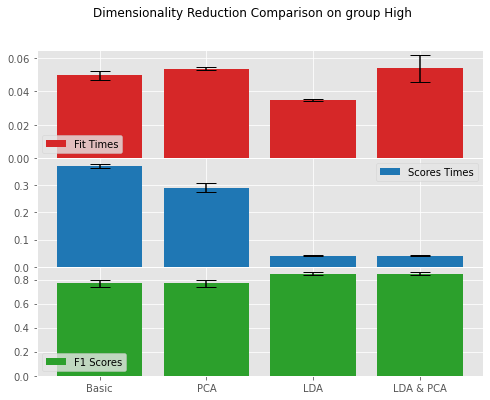

Average-High : Average-High data with shape (77725, 35) - 2 categories
> basic
> pca
> lda
> pca_lda


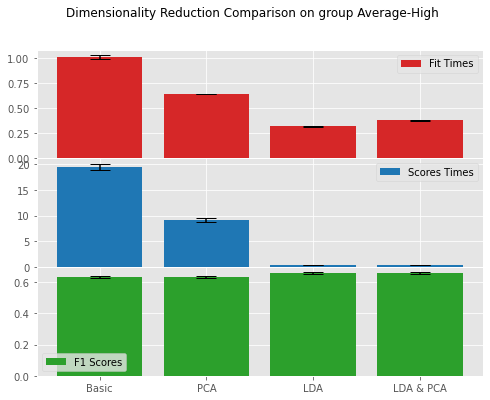

Average-Low : Average-Low data with shape (43025, 35) - 2 categories
> basic
> pca
> lda
> pca_lda


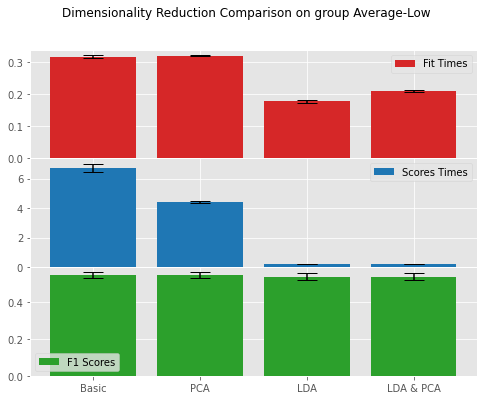

Low : Low data with shape (11879, 35) - 2 categories
> basic
> pca
> lda
> pca_lda


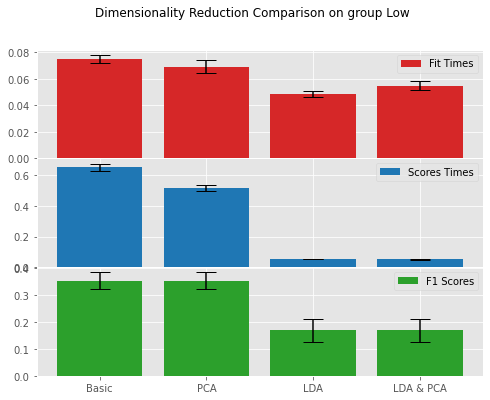

Null : Null data with shape (3345, 35) - 2 categories
> basic
> pca
> lda
> pca_lda


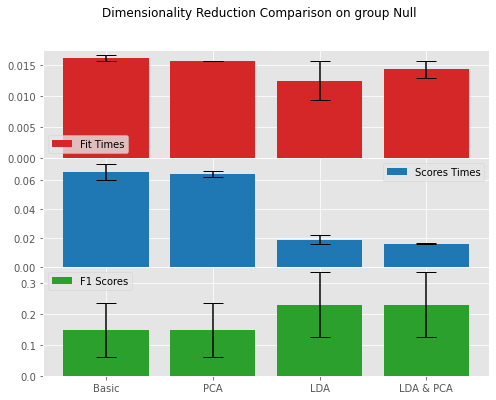

------------------------------------------------------------


In [10]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import sem


def cv_test_pipelines(X, y, pipelines, plot=False, **kwargs):
    # create lists to store values
    fit_times, fit_times_err = [], []
    score_times, score_times_err = [], []
    test_scores, test_scores_err = [], []

    for model in pipelines:
        try:
            print(">", model.steps[1][0])
        except AttributeError:
            print(">", model)

        # store k-fold cv scores
        results = cross_validate(model, X, y, **kwargs)

        # add means/errs to lists
        fit_times.append(results["fit_time"].mean())
        fit_times_err.append(sem(results["fit_time"]))
        score_times.append(results["score_time"].mean())
        score_times_err.append(sem(results["score_time"]))
        test_scores.append(results["test_score"].mean())
        test_scores_err.append(sem(results["test_score"]))

    return {"fit_times": (fit_times, fit_times_err),
            "score_times": (score_times, score_times_err),
            "test_scores": (test_scores, test_scores_err)}


# create pipelines
model_basic = Pipeline([("scaler", StandardScaler()),
                        ("basic", KNeighborsClassifier(n_neighbors=n))])
model_lda = Pipeline([("scaler", StandardScaler()),
                      ("lda", LinearDiscriminantAnalysis()),
                      ("predictive", KNeighborsClassifier(n_neighbors=n))])
model_pca = Pipeline([("scaler", StandardScaler()),
                      ("pca", PCA()),
                      ("predictive", KNeighborsClassifier(n_neighbors=n))])
model_pca_lda = Pipeline([("scaler", StandardScaler()),
                          ("pca_lda", PCA()),
                          ("lda", LinearDiscriminantAnalysis()),
                          ("predictive", KNeighborsClassifier(n_neighbors=n))])
models = (model_basic, model_pca, model_lda, model_pca_lda)


# for each database
for k, v in data.items():
    # prepare data
    print(k.title())
    x, y = v.unpack()

    # group by spacegroup mean success rate
    if k == "dials":
        n, grp_names = 4, ["High", "Average", "Low", "Null"]
    elif k == "3dii":
        n, grp_names = 5, ["High", "Average-High", "Average-Low", "Low", "Null"]
    grped_data = GroupedSpacegroup(x, y)
    grped_data.group(n=n, names=grp_names, auto_sort=True)

    # prepare ungrouped figure
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(8, 6))
    fig.subplots_adjust(hspace=0)  # remove horizontal axes space
    hoz = np.arange(len(models))  # for basic, pca and lda models

    # set scoring parameters
    cv, scoring = 5, "f1"  # stratified KFold & accuracy used as default
    results = cv_test_pipelines(x.drop("SPACEGROUP", axis=1), y, models, cv=cv, scoring=scoring)
    fit_times, fit_times_err = results["fit_times"]
    score_times, score_times_err = results["score_times"]
    test_scores, test_scores_err = results["test_scores"]

    # create bar plots
    ax0.bar(hoz, fit_times, yerr=fit_times_err, capsize=10, label="Fit Times", color="tab:red")
    ax1.bar(hoz, score_times, yerr=score_times_err, capsize=10, label="Score Times", color="tab:blue")
    ax2.bar(hoz, test_scores, yerr=test_scores_err, capsize=10, label="F1 Scores", color="tab:green")

    # add xticks & legend
    ax2.set_xticks(hoz)
    ax2.set_xticklabels(["Basic", "PCA", "LDA", "PCA & LDA"])
    ax0.legend(); ax1.legend(); ax2.legend()
    fig.suptitle(f"Dimensionality Reduction Comparison on ungrouped data")
    plt.show()

    # repeat for each spacegroup cluster
    for i, datum in grped_data:
        print(i, ":", datum)
        # prepare data and figure
        x_datum, y_datum = datum.unpack(drop_col="SPACEGROUP")
        fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(8, 6))
        fig.subplots_adjust(hspace=0)  # remove horizontal axes space

        # set scoring parameters
        cv, scoring = 5, "f1"  # stratified KFold & accuracy used as default
        results = cv_test_pipelines(x_datum, y_datum, models, cv=cv, scoring=scoring)
        fit_times, fit_times_err = results["fit_times"]
        score_times, score_times_err = results["score_times"]
        test_scores, test_scores_err = results["test_scores"]

        # create bar plots
        ax0.bar(hoz, fit_times, yerr=fit_times_err, capsize=10, label="Fit Times", color="tab:red")
        ax1.bar(hoz, score_times, yerr=score_times_err, capsize=10, label="Scores Times", color="tab:blue")
        ax2.bar(hoz, test_scores, yerr=test_scores_err, capsize=10, label="F1 Scores", color="tab:green")

        # add xticks & legend
        ax2.set_xticks(hoz)
        ax2.set_xticklabels(["Basic", "PCA", "LDA", "PCA & LDA"])
        ax0.legend(); ax1.legend(); ax2.legend()
        fig.suptitle(f"Dimensionality Reduction Comparison on group {i}")
        plt.show()

    print("-" * 60)


The figures above show the fit/score times and the f1 score of each model on each dataset. The following remarks can be made:

- **F1 scores vary significantly** between each spacegroup cluster, highest for high success rate cluster.
- **LDA/both has lower fit/score times than both PCA and basic models**.
- Between basic and PCA, **PCA usually offers slightly longer fit times for significantly shorter score times**.
- **Performance similar among models**, except for a few outliers, in which LDA can provide anything from a slight increase to a massive decrease in performance.
- **Performance decreases as number of failure dominates number of successes** due to sample imbalance (so higher success rate clusters perform significantly better than low ones).

LDA usually has lower performance than the other two models, and as such the choice of optimal model is between the latter pair. From these, who have similar performance, PCA offers a shorter score time, which makes it the choice of optimal model.

**Optimal Models** - PCA or LDA